### calculate the South Pacific Subtropical Index from the ERSST V5 dataset


see:  
    
+ [https://climatedataguide.ucar.edu/climate-data/sst-data-noaa-extended-reconstruction-ssts-version-5](https://climatedataguide.ucar.edu/climate-data/sst-data-noaa-extended-reconstruction-ssts-version-5) 
+ [ftp://ftp.ncdc.noaa.gov/pub/data/cmb/ersst/v4/netcdf/](ftp://ftp.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/)
+ http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc (for access via OpenDAP)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
from datetime import (datetime, timedelta)
from dateutil import parser
from scipy.stats import zscore

In [3]:
import xarray as xr

In [4]:
HOME = pathlib.Path.home()

### access the ERSST dataset remotely (ESRL Thredds server: No need for download)

In [5]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"

In [6]:
dset = xr.open_dataset(url, drop_variables=["time_bnds"])

### latitudes in ascending order 

In [7]:
dset = dset.sortby('lat')

### check what is the last month in the data 

In [8]:
dset.time[-1].data

array('2021-10-01T00:00:00.000000000', dtype='datetime64[ns]')

### keep only the data post 1950

In [9]:
dset = dset.sel(time=slice('1950', None))

### loads in memory 

In [10]:
dset = dset.compute()

### function to remove climatological average

In [11]:
def demean(x): 
    return x - x.sel(time=slice('1981','2010')).mean('time')

### calculates the anomalies WRT to climatology

In [12]:
sst_anoms = dset['sst'].groupby('time.month').apply(demean)

### calculates the SPSD

The SPSD is calculated as the standardised difference between the monthly SST anomalies in the northwest subtropical Pacific (50-35S / 170E-10W) and the southeast extra-tropical Pacific (57.5 - 45S, 140E - 120W) from the ERSST SST dataset

### extract the NW pole of the dipole

In [13]:
NW_pole = sst_anoms.sel(lat=slice(-50.,-35), lon=slice(170.,190.)).mean('lat').mean('lon')

In [14]:
NW_pole = NW_pole.to_dataframe()[['sst']]

In [15]:
NW_pole.columns = ['NW_pole']

In [16]:
NW_pole.head()

,NW_pole
time,
1950-01-01,0.636040
1950-02-01,0.008213
1950-03-01,-0.386838
1950-04-01,0.098148
1950-05-01,0.379086


### extract the SE pole of the dipole

In [17]:
SE_pole = sst_anoms.sel(lat=slice(-57.5,-45.), lon=slice(220.,240.)).mean('lat').mean('lon')

In [18]:
SE_pole = SE_pole.to_dataframe()[['sst']]

In [19]:
SE_pole.columns = ['SE_pole']

In [20]:
SE_pole.head()

,SE_pole
time,
1950-01-01,-0.544901
1950-02-01,-0.979526
1950-03-01,-1.610508
1950-04-01,-0.630996
1950-05-01,0.046073


### concatenate

In [21]:
df = pd.concat((NW_pole, SE_pole), axis=1)

In [22]:
df.head()

,NW_pole,SE_pole
time,,
1950-01-01,0.636040,-0.544901
1950-02-01,0.008213,-0.979526
1950-03-01,-0.386838,-1.610508
1950-04-01,0.098148,-0.630996
1950-05-01,0.379086,0.046073


In [23]:
df.tail()

,NW_pole,SE_pole
time,,
2021-06-01,0.687141,-0.437349
2021-07-01,0.610896,-0.484914
2021-08-01,0.474666,-0.442260
2021-09-01,0.396359,-0.482014
2021-10-01,0.446818,-0.463856


### normalise the 2 poles of the indices (WRT climatological period average and standard-deviation)

In [24]:
dfs = ( df - df.loc['1981':'2010',:].mean() ) / df.loc['1981':'2010',:].std()

### calculates the dipole index

In [25]:
dfs.loc[:,'SPSD'] = dfs.loc[:,'NW_pole'] - dfs.loc[:,'SE_pole']

<AxesSubplot:xlabel='time'>

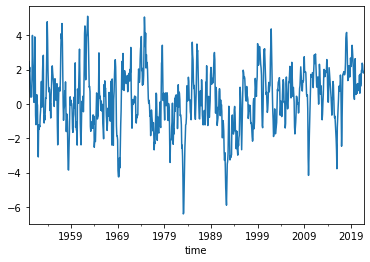

In [26]:
dfs.loc[:,'SPSD'].plot()

### normalise

In [27]:
dfs.loc[:,'SPSDsd'] = ( dfs.loc[:,'SPSD'] - dfs.loc['1981':'2010','SPSD'].mean() ) / dfs.loc['1981':'2010','SPSD'].std()

<AxesSubplot:xlabel='time'>

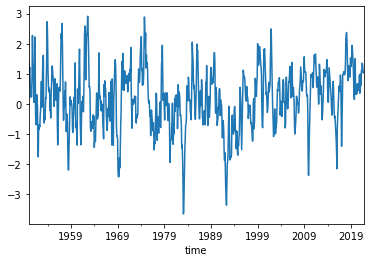

In [28]:
dfs.loc[:,'SPSDsd'].plot()

In [29]:
dfs

,NW_pole,SE_pole,SPSD,SPSDsd
time,,,,
1950-01-01,1.438770,-1.016750,2.455520,1.401213
1950-02-01,0.018578,-1.827729,1.846307,1.053573
1950-03-01,-0.875056,-3.005100,2.130044,1.215484
1950-04-01,0.222019,-1.177397,1.399416,0.798560
1950-05-01,0.857521,0.085969,0.771552,0.440277
...,...,...,...,...
2021-06-01,1.554365,-0.816065,2.370429,1.352656
2021-07-01,1.381892,-0.904817,2.286709,1.304883
2021-08-01,1.073730,-0.825228,1.898958,1.083617


### select just the dipole mode 

In [30]:
spsd = dfs.loc[:,['SPSDsd']]

In [31]:
spsd.columns = ['SPSD_monthly']

### calculates the seasonal anomalies 

In [32]:
spsds = spsd.rolling(window=3, min_periods=3).mean()

In [33]:
spsds.columns =  ['SPSD_seasonal']

In [34]:
spsd = pd.concat([spsd, spsds], axis=1)

### shift to month end 

In [35]:
spsd.index = spsd.index + pd.offsets.MonthEnd(0)

In [36]:
spsd.index.name = 'date'

In [37]:
opath = pathlib.Path("/media/nicolasf/END19101/data/climate_indices/observed/SPSD")

In [38]:
if not opath.exists(): 
    opath.mkdir(parents=True)

In [39]:
spsd.to_csv(opath.joinpath("SPSD.csv"))

In [40]:
spsd.tail()

,SPSD_monthly,SPSD_seasonal
date,,
2021-06-30,1.352656,1.194595
2021-07-31,1.304883,1.259729
2021-08-31,1.083617,1.247052
2021-09-30,1.024866,1.137789
2021-10-31,1.070665,1.059716


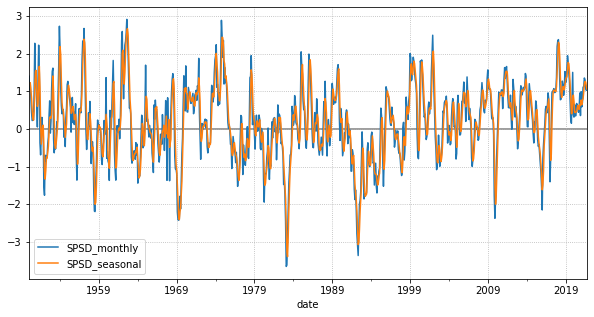

In [42]:
f, ax = plt.subplots(figsize=(10,5))
spsd.plot(ax=ax, legend=['monthly','seasonal'])
ax.grid(ls=':')
ax.axhline(0., zorder=-1, color='k', alpha=0.5)